In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

image_dir = Path('D:/Image Classification/Indian Food Images')


filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    num_samples = min(100, len(category_slice)) 
    category_samples.append(category_slice.sample(num_samples, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)



In [24]:
image_df['Label'].value_counts()


Label
chapati        50
biryani        50
mango+lassi    10
kebab          10
Name: count, dtype: int64

In [25]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)


In [26]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [27]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 68 validated image filenames belonging to 4 classes.
Found 16 validated image filenames belonging to 4 classes.
Found 36 validated image filenames belonging to 4 classes.


In [28]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [29]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,438,980 (9.30 MB)

 Trainable params: 180,996 (707.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [30]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    # callbacks=[
    #     tf.keras.callbacks.EarlyStopping(
    #         monitor='val_loss',
    #         patience=3,
    #         restore_best_weights=True
    #     )
    # ]
)

Epoch 1/10


c:\Users\shriram\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4925 - loss: 1.1234 - val_accuracy: 0.7500 - val_loss: 0.8359
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 455ms/step - accuracy: 0.8860 - loss: 0.4126 - val_accuracy: 0.8750 - val_loss: 0.4978
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 646ms/step - accuracy: 0.9926 - loss: 0.1639 - val_accuracy: 0.9375 - val_loss: 0.3481
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 633ms/step - accuracy: 0.9926 - loss: 0.0649 - val_accuracy: 0.9375 - val_loss: 0.3523
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 638ms/step - accuracy: 1.0000 - loss: 0.0287 - val_accuracy: 0.9375 - val_loss: 0.4550
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 1.0000 - loss: 0.0234 - val_accuracy: 0.9375 - val_loss: 0.5208
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9375 - val_loss: 0.5167
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 1.0000 - loss: 0.0057 - val_accuracy: 0.9375 - val_loss: 0.4684
Epoch

In [31]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

model.save('model.h5')

print("Model saved as 'model.h5'")



Test Accuracy: 97.22%
Model saved as 'model.h5'


In [32]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


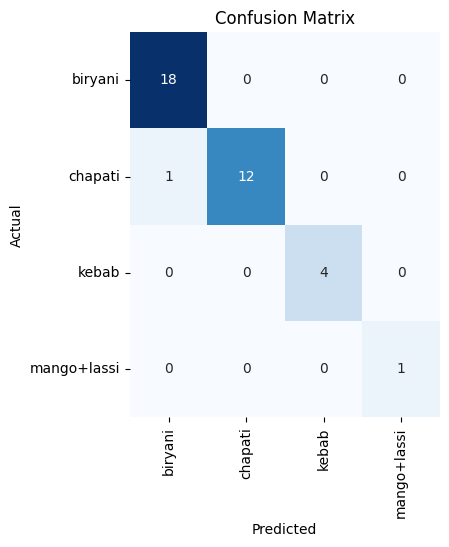

In [35]:
plt.figure(figsize=(4,5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(4) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [36]:
print("Classification Report:\n----------------------\n", clr)


Classification Report:
----------------------
               precision    recall  f1-score   support

     biryani       0.95      1.00      0.97        18
     chapati       1.00      0.92      0.96        13
       kebab       1.00      1.00      1.00         4
 mango+lassi       1.00      1.00      1.00         1

    accuracy                           0.97        36
   macro avg       0.99      0.98      0.98        36
weighted avg       0.97      0.97      0.97        36



In [20]:
import requests

def get_nutrient_info(food_name):
    api_key = '7PIXBDs3bVpYAXULAyWGTHQLhmSJi6roVWGtK5Rn'
    url = f'https://api.nal.usda.gov/fdc/v1/foods/search?query={food_name}&api_key={api_key}'
    
    response = requests.get(url)
    data = response.json()
    
    if 'foods' in data and len(data['foods']) > 0:
        food = data['foods'][0]
        nutrient_info = {
            'Food Name': food['description'],
            'Nutrients': {nutrient['nutrientName']: nutrient['value'] for nutrient in food['foodNutrients']}
        }
        return nutrient_info
    else:
        return None
    
    

In [37]:
print("Class Indices:", test_images.class_indices)
print("Predictions:", predictions)


Class Indices: {'biryani': 0, 'chapati': 1, 'kebab': 2, 'mango+lassi': 3}
Predictions: [2 1 2 0 3 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 2 2 1 0 0 1 0 1 1 1 0 0 0 1 0]


In [38]:
model.save('model.h5')

print("Model saved as 'model.h5'")

Model saved as 'model.h5'


In [70]:
# for i, prediction in enumerate(predictions):
#     predicted_class_index = prediction  # Since predictions are already indices
#     predicted_class = list(test_images.class_indices.keys())[predicted_class_index]
#     classified_image_path = test_df.iloc[i]['Filepath']
#     nutrient_info = get_nutrient_info(predicted_class)
#     print("Predicted Class:", predicted_class)
#     print("Nutrient Information:"
#     , nutrient_info)
#     print()


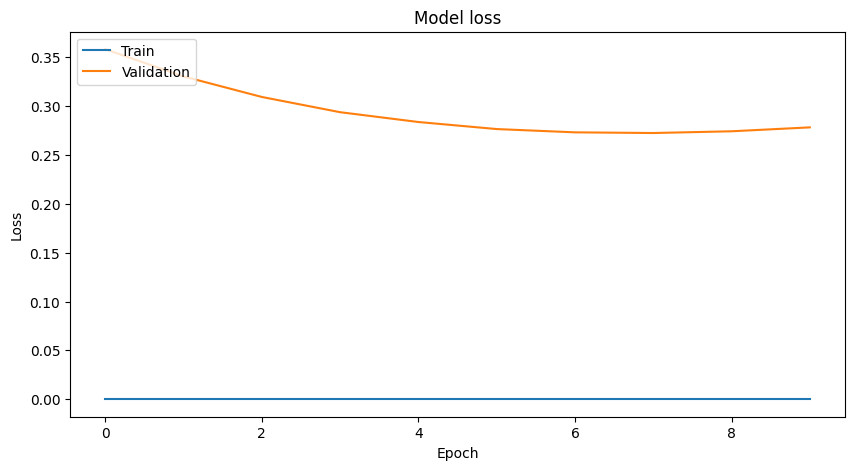

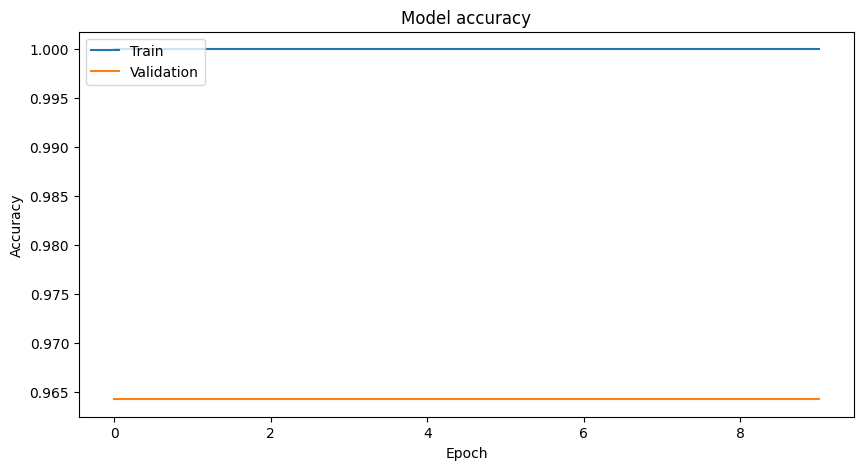

In [22]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    # Plot training & validation loss values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation accuracy values
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_loss_accuracy(history)